In [102]:
# helper functions

from skimage import filters, morphology
from rasterio import features 
from shapely.geometry import shape
from shapely import geometry
import itertools

def wgs2epsg(x,y):
    EPSG = int(32700-round((45+y)/90,0)*100+round((183+x)/6,0))
    UTM_EPSG_code = EPSG
    
    return UTM_EPSG_code


def array_to_linestrings(array, mask, affine):
    
    if np.all(mask) == True:
        final_lines = []
    else:
        # Convert the array to polygon geometries
        polygon_generator = features.shapes(array.astype('uint8'), mask=array, transform=affine)
        # Extract out the individual polygons, fixing any invald geometries using buffer(0)
        polygons = [shape(g).buffer(0) for g,v in polygon_generator]

        # Next, build up a binary array representing the outer boundary of the input array
        boundary_array = np.ones(array.shape)    

        # Convert the boundary to a polygon too
        boundary_generator = features.shapes(boundary_array.astype('uint8'), transform=affine)
        boundary = [shape(g) for g,v in boundary_generator][0]

        # Convert the mask to a polygon too
        if mask is not None:
            
            mask_generator = features.shapes(mask.astype('uint8'), 
                                             mask= mask > 0,
                                             transform=affine)
            mask_boundary = [shape(g).buffer(0) for g,v in mask_generator][0]

        # Convert the array polygons to linestrings
        exterior_rings = [g.exterior for g in polygons]
        interior_rings = list(itertools.chain.from_iterable([[i for i in g.interiors] for g in polygons if len(g.interiors) > 0]))
        all_rings =  exterior_rings + interior_rings 

        # Erase both the image boundary and the mask boundary from the extracted Linestrings
        erased_lines = all_rings #[g.difference(boundary.exterior).difference(mask_boundary.exterior) for g in all_rings]
        singlepart_lines = [list(g) if type(g) == geometry.multilinestring.MultiLineString else [g] for g in erased_lines ]
        final_lines = list(itertools.chain(*singlepart_lines))

    return final_lines 

def check_valid_geometries(shapefile_path):
    
    shape_list = []

    for pol in fiona.open(shapefile_path):
        if pol['geometry'] != None:
#             if pol['geometry']['type'] == 'MultiPolygon':
#                 for sub_pol in pol['geometry']['coordinates']:
#                     pol = sub_pol[0]
#                     shape_list.append(pol)
#             else:
                shape_list.append(pol)
            
    return shape_list

# load classified raster

In [354]:
# load classified rasters 

import rasterio 
import glob

from pprint import pprint

from shapely.ops import cascaded_union

# find files in classification folder
raster_files_path = '../../TreeTect/data/raster_classifications/classification_Setu*.tif'
raster_files = glob.glob(raster_files_path)
file_path = raster_files[0]

print(len(raster_files))
print('-------------------------------------')
pprint(raster_files)
print('-------------------------------------')
print(file_path)

data = rasterio.open(file_path).read()
dataset = rasterio.open(file_path)

affine = dataset.meta['transform']
width = dataset.meta['width']
height = dataset.meta['height']

2
-------------------------------------
['../../TreeTect/data/raster_classifications/classification_Setu_mangga_bolong_2019-05-31_03:28_104001004CBD1F00.tif',
 '../../TreeTect/data/raster_classifications/classification_Setu_babakan_2019-05-31_03:28_104001004CBD1F00.tif']
-------------------------------------
../../TreeTect/data/raster_classifications/classification_Setu_mangga_bolong_2019-05-31_03:28_104001004CBD1F00.tif


In [355]:
import numpy as np
# scikit-image modules for image science operators


# Remove noise

In [356]:
# Specify the minimum feature size in square meters, and then use info from the image metadata 
# to translate to grid cell count.

# Set the minimum feature size to 400 sq km (400,000 m)
min_feature_size_m2 = 80.

# From the image metadata, we can determine the area of a single grid cell
try: 
    cell_height_m = image.rda.metadata['image']['groundSampleDistanceMeters']
except: 
    cell_height_m = 0.40
    
cell_area_m2 = cell_height_m**2

# Finally, use the cell size to convert the minimum feature size to grid cells
min_feature_size_cells = np.round((min_feature_size_m2/cell_area_m2)).astype('int64')

# What is the minimum feature size in square meters and grid cells?
print(min_feature_size_m2, 'sq. m')
print(min_feature_size_cells, 'grid cells')

# scikit-image modules for image science operators
from skimage import filters, morphology

# First, remove the small holes
water_cleaned = morphology.remove_small_holes(data.astype(int), min_feature_size_cells / 4)

# Then remove the small objects
water_cleaned = morphology.remove_small_objects(water_cleaned, min_feature_size_cells, connectivity=2)


80.0 sq. m
500 grid cells


/home/chris/anaconda3/envs/GISpy_1/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?


In [357]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Cleaned Water Mask')

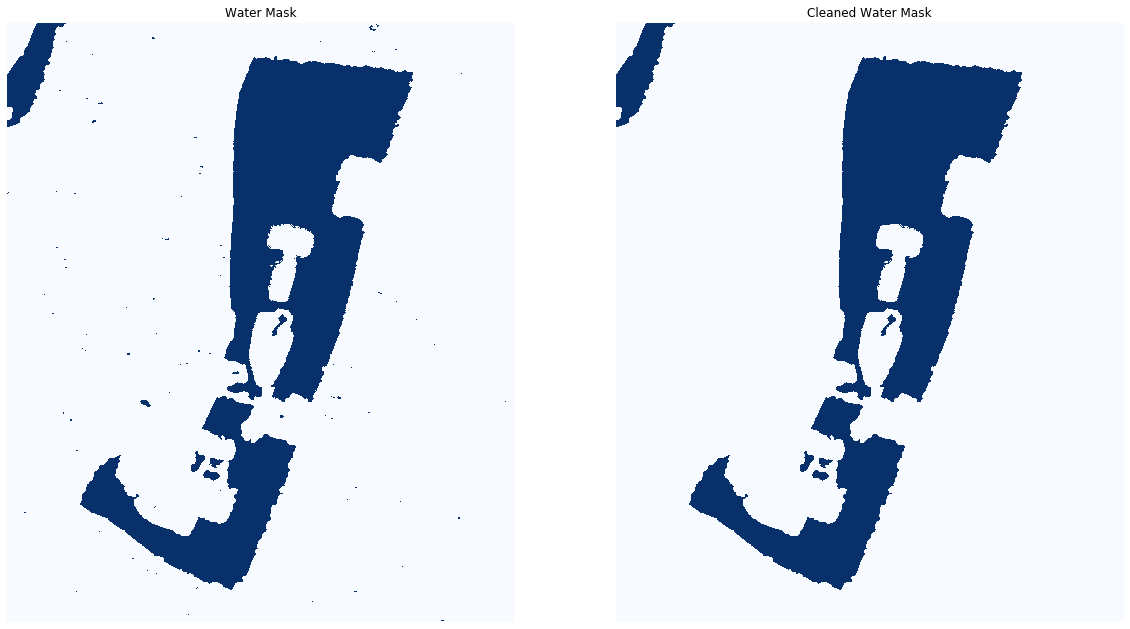

In [358]:
# # View the results
plt.figure(figsize=(20,15))
# plt.subplot(1, 3, 1)
# plt.axis('off')
# # plt.imshow(rgb)
# plt.title("RGB")

plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(data[0], vmin=0, vmax=1, cmap = 'Blues')
plt.title("Water Mask")

plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(water_cleaned[0], vmin=0, vmax=1, cmap = 'Blues')
plt.title("Cleaned Water Mask")

## GBDX method

In [359]:
water_lines = array_to_linestrings(array = water_cleaned, mask = water_cleaned, affine = affine)

# Run a basic simplification algorithm to smooth the lines
water_lines_smooth = [g.simplify(0.001) for g in water_lines]

# GLue it all together
setu = cascaded_union(water_lines)

## Buffer smooth

In [360]:
import shapely.ops as ops
# setu_smooth = setu_wgs.simplify(0.00003)
setu_poly = ops.polygonize_full(setu)

setu_poly[1]

setu_poly = cascaded_union(setu_poly)

buffer = 3e-05

setu_poly_smooth = setu_poly.buffer(-buffer).buffer(buffer)



### reproject shapes

In [361]:
x,y  = setu_poly_smooth.centroid.xy

epsg = wgs2epsg(x[0], y[0])

epsg

32748

In [362]:
from shapely.ops import transform
from shapely import ops
from functools import partial
import pyproj

# set projections
project_wgs2utm = partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:4326'),
    pyproj.Proj(init='epsg:{}'.format(epsg)))

project_utm2wgs = partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:{}'.format(epsg)), # from
    pyproj.Proj(init='epsg:4326'))            # to

In [363]:
setu_utm = transform(project_wgs2utm, setu)

setu_wgs = setu

In [364]:
setu_utm_buffer = setu_utm.buffer(4.5)

In [365]:
setu_wgs_buffer_zone = transform(project_utm2wgs, setu_utm_buffer)



In [366]:
from shapely.affinity import translate

In [367]:
x_offset =  -2.1237475792190708e-05
y_offset =  4.0165100771538675e-05

In [368]:
shift_wgs_buffer_zone = translate(setu_wgs_buffer_zone, xoff = x_offset, yoff = y_offset, zoff=0.0)

shift_wgs = translate(setu_wgs,xoff = x_offset, yoff = y_offset, zoff=0.0)

In [369]:
shift_wgs.centroid.xy[0][0], shift_wgs.centroid.xy[1][0]

(106.82152403523057, -6.35059117238997)

# load reference data

In [370]:
drone_shapes_path = '../../DT4D/green_blue_tool/Ground_truth_data/lines_georef/*.shp'

# find files in shapefile folder
drone_shape_files = glob.glob(drone_shapes_path)

drone_shape_files[4]

from shapely.ops import cascaded_union
import fiona
# convert esri shapefiles to shapely objects

# check valid geometries
drone_valid_shape_list = check_valid_geometries(drone_shape_files[4])

# convert list to shapely MultiPolgyons

drone_MultiPoly = cascaded_union([shape(pol['geometry']) for pol in drone_valid_shape_list])


print('number of polygons class 1: ', len(drone_MultiPoly))

number of polygons class 1:  5


In [371]:
drone_MultiPoly_wgs = transform(project_utm2wgs,drone_MultiPoly)

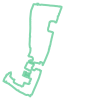

In [372]:
drone_MultiPoly_wgs_exterior = cascaded_union([poly.exterior for poly in drone_MultiPoly_wgs])

drone_MultiPoly_wgs_exterior

In [373]:
shift_wgs_buffer_zone.intersection(drone_MultiPoly_wgs_exterior).length / drone_MultiPoly_wgs_exterior.length

0.9830295323540212

## visualize results

In [374]:
import folium

m = folium.Map([setu.centroid.y, setu.centroid.x],  zoom_start = 16, 
               tiles = 'https://{s}.basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}{r}.png',
              attr='CartoDB')

folium.TileLayer('https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',attr='esri', name = 'esri Imagery').add_to(m)


# folium.raster_layers.ImageOverlay(
#     image=image.rgb(),
#     name='image 2017',
#     bounds=[[bbox[1], bbox[0]],[bbox[3],bbox[2]]],
#     opacity=1,
#     interactive=False,
#     cross_origin=False,
#     zindex=1, 
#     colormap=lambda x: (0,0,0, x)
# ).add_to(m)

# folium.raster_layers.ImageOverlay(
#     image=classification_plot,
#     name='Classification 2017',
#     bounds=[[bbox[1], bbox[0]],[bbox[3],bbox[2]]],
#     opacity=1,
#     interactive=False,
#     cross_origin=False,
#     zindex=1, 
#     colormap=lambda x: (0,x,x, 1)
# ).add_to(m)


# folium.Choropleth(setu_wgs, name = 'Setu water delineation').add_to(m)

folium.Choropleth(drone_MultiPoly_wgs_exterior, name = 'drone line').add_to(m)

folium.Choropleth(setu_wgs_buffer_zone, name = 'buffer zone', line_color = 'black').add_to(m)

folium.Choropleth(shift_wgs_buffer_zone, name = 'shifted buffer zone', line_color = 'black', facecolor = 'red').add_to(m)

folium.Choropleth(shift_wgs, name = 'shifted line', line_color = 'black', facecolor = 'red').add_to(m)







# f_smooth = [0.00001,0.00002,0.00003,0.00004,0.00006,0.00008]

# for i in f_smooth:
#     setu_smooth = setu_wgs.simplify(i)
#     folium.Choropleth(setu_smooth, name = 'smooth setu delineation'.format(i)).add_to(m)
# # 

# for point in range(0, len(locationlist)):
#     folium.Marker(locationlist[point], popup=df['ActualDBH'][point], group  = "Tree removals").add_to(m)

folium.LayerControl().add_to(m)

In [375]:
m

In [376]:
m.save('index.html')


## Write to shape

In [199]:
# we use ogr to write shapefiles
from osgeo import ogr

In [219]:
setu_poly = ops.polygonize_full(shift_wgs)

In [220]:
setu_poly

(<shapely.geometry.collection.GeometryCollection at 0x7f3cd6181950>,
 <shapely.geometry.collection.GeometryCollection at 0x7f3cd6d4a7d0>)

In [221]:
name = 'Setu_mangga_bolong'

path = '../../TreeTect/data/shapefiles_waterbodies_results/{}_result_shape.shp'.format(name)

your_shape = setu_poly

# Now convert it to a shapefile with OGR    
driver = ogr.GetDriverByName('Esri Shapefile')
ds = driver.CreateDataSource(path)
layer = ds.CreateLayer('', None, ogr.wkbPolygon)
# Add one attribute
layer.CreateField(ogr.FieldDefn('id', ogr.OFTInteger))
defn = layer.GetLayerDefn()

i = 0

## If there are multiple geometries, put the "for" loop here
for poly in your_shape:

    # Create a new feature (attribute and geometry)
    feat = ogr.Feature(defn)
    feat.SetField('id', i)
    # print(id_list[i])

    # Make a geometry, from Shapely object
    geom = ogr.CreateGeometryFromWkb(poly.wkb)
    feat.SetGeometry(geom)

    layer.CreateFeature(feat)
    feat = geom = None  # destroy these
    
    
    i = i + 1 
    

# Save and close everything
ds = layer = feat = geom = None

# other methods

## Contour method (needs fix)

In [89]:
Z = water_cleaned.astype(int)
Z = np.fliplr(Z[0])

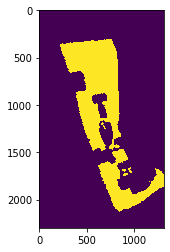

In [90]:
plt.imshow(Z)

In [91]:
affine = dataset.meta['transform']
width = dataset.meta['width']
height = dataset.meta['height']

In [92]:
x_pix_size, row_rotation, x_orig, col_rotation, y_pix_size, y_orig, g, h, i = affine[:]

In [93]:
from skimage import measure
contours = measure.find_contours(Z, 0,)

for i in range(len(contours)):

    contours[i][:,0] = (contours[i][:,0] * x_pix_size) + x_orig

    contours[i][:,1] = (contours[i][:,1] * y_pix_size) + y_orig
    
    print(len(contours[i]))

4492
3
3
3
3
3
3
5
5
7
7
3
3
3
3
3
3
857
268
3
3
3
3
3
3
3
3
3
3
3
3
7
3
3
3
3
5
3
5
3
3
9
72
3
3
5
5
3
3
5
7
3
5
5
9
3
3
5
3
5
9
5
7
3
3
5
3
7
15
3
3
3
7
5
5
15
7
3
3
3
7
11
3
3
7
7
3
3
3
3
3
183
3
3
3
3
3
3
5
5
2819
3
192
147
3
137


In [94]:
contours[0]

array([[106.82452754,  -6.34876015],
       [106.8245245 ,  -6.34875711],
       [106.8245245 ,  -6.34875406],
       ...,
       [106.82452145,  -6.3487632 ],
       [106.8245245 ,  -6.3487632 ],
       [106.82452754,  -6.34876015]])

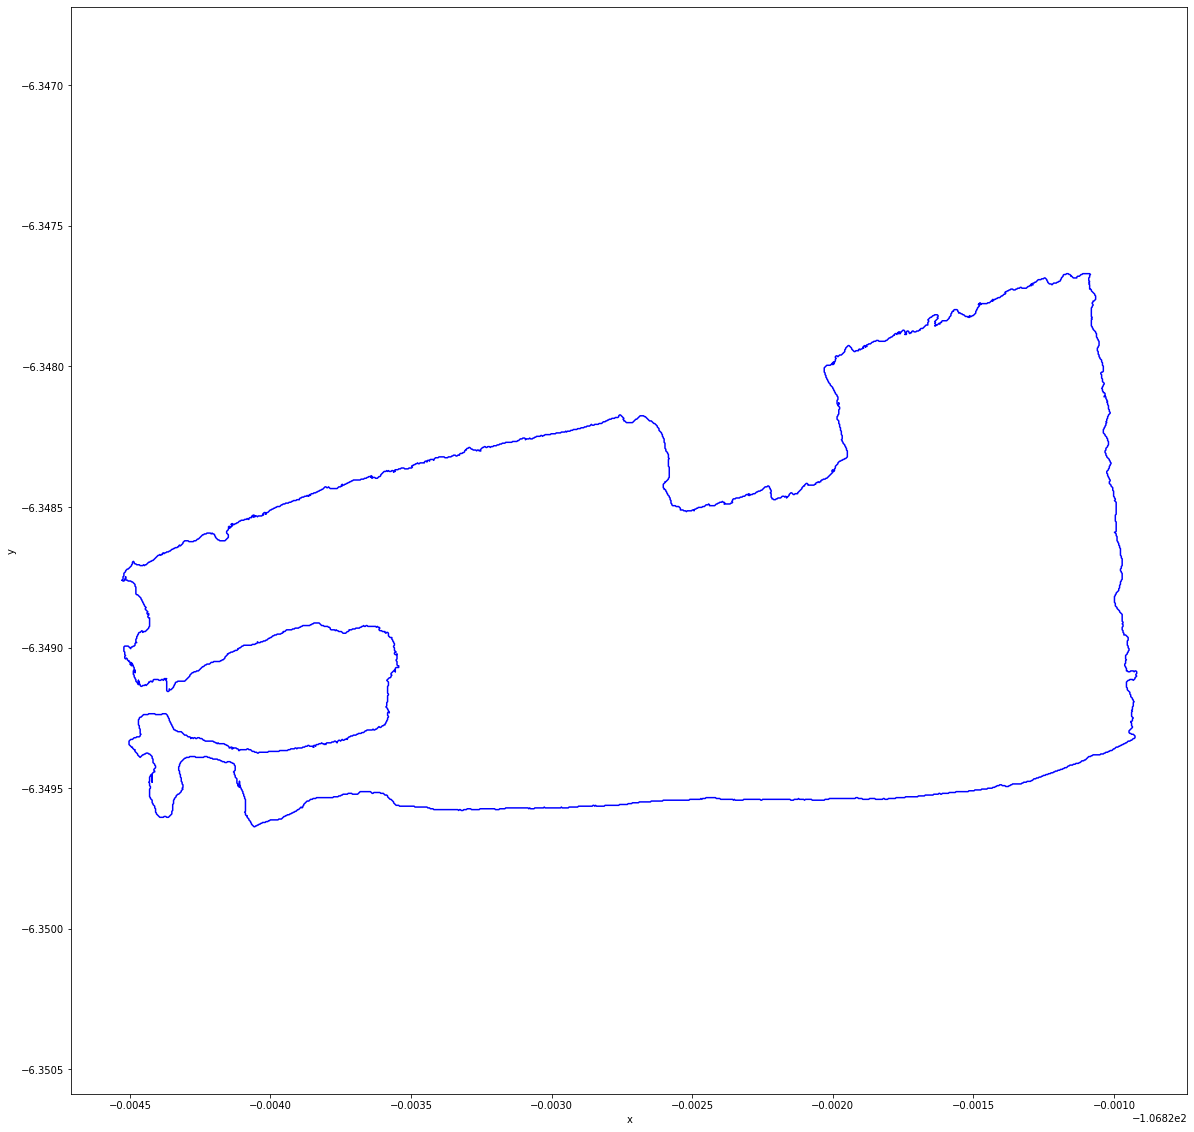

In [95]:
# for i in range(len(contours)):

import numpy as np
from scipy.interpolate import splprep, splev
import matplotlib.pyplot as plt

nr = 0

x = contours[nr][:,0] *-1
y = contours[nr][:,1]

if len(x) > 20:

    plt.figure(figsize = (20,20))
    plt.axis('equal')
    plt.plot(x,y,color = 'b'); plt.xlabel('x'); plt.ylabel('y'); # plt.gca().invert_yaxis()
    plt.show()


    # define pts from the question
    

#     tck, u = splprep(pts.T, u=None, s=0.0, per=1) 
#     u_new = np.linspace(u.min(), u.max(), 150)            
#     x_new, y_new = splev(u_new, tck, der=0)

#     x_new = x_new * -1

#     fig, ax = plt.subplots(figsize = (20,20))
# #         plt.plot(pts[:,1], pts[:,0], 'r.')
#     plt.plot(x_new, y_new, 'b-')
#     plt.axis('equal'); plt.legend(); plt.xlabel('x'); plt.ylabel('y');
#     plt.show()

In [96]:
from shapely.geometry import Polygon

contour_polygons = []

buffer = 0.00001

for contour in contours:

    buffer_smooth = Polygon([tuple((point[1],point[0]*-1)) for point in contour]).buffer(buffer).buffer(buffer  * -1)
    
    contour_polygons.append(buffer_smooth)
    

In [97]:
buffer_smooth_polygons = cascaded_union(contour_polygons)

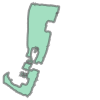

In [98]:
buffer_smooth_polygons

In [99]:
buffer_smooth_polygons.centroid.xy

(array('d', [-6.349083923662251]), array('d', [-106.82328204528027]))

## Interpolation tests

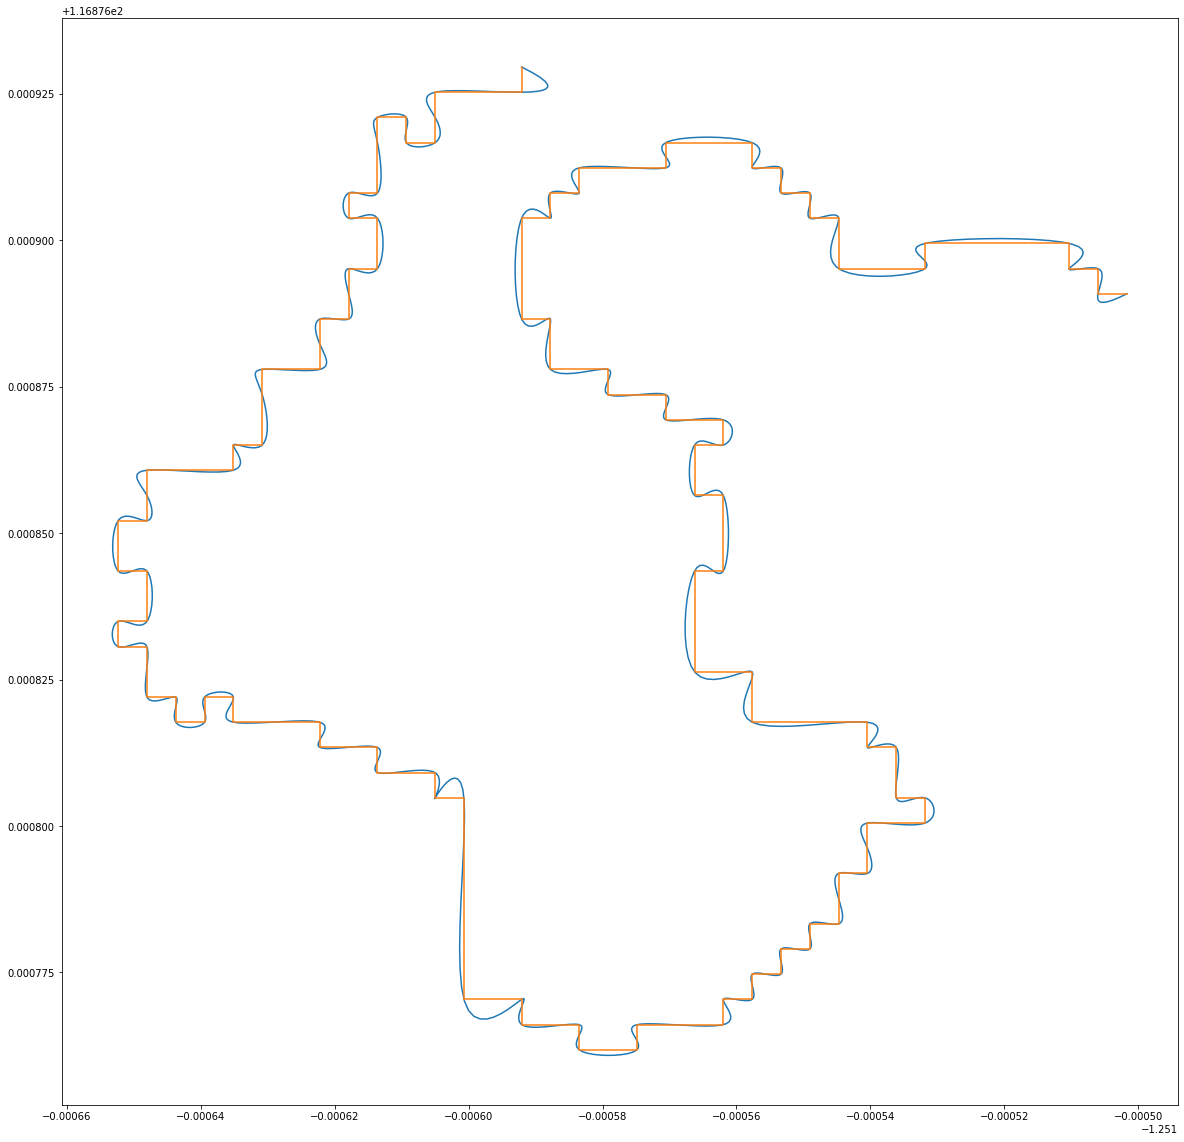

In [51]:
import scipy.interpolate as si

Multi = setu[2]

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

x = np.array(Multi.coords[:])[:,1]
y = np.array(Multi.coords[:])[:,0]

t = np.arange(len(x))
ti = np.linspace(0, t.max(), 10 * t.size)

xi = interp1d(t, x, kind='cubic')(ti)
yi = interp1d(t, y, kind='cubic')(ti)

fig, ax = plt.subplots(figsize = (20,20))
ax.plot(xi, yi, )
ax.plot(x, y)
ax.margins(0.05)
plt.show()

In [66]:
i = 0
for poly in setu_poly:
    
    print(i, poly.area)
    i = i + 1

0 3.7030078006712726e-11
1 5.5545117009113653e-11
2 1.85150390645044e-11
3 1.8515039002400927e-11
4 1.8515039003356363e-11
5 3.703007800575729e-11
6 1.8515039063548962e-11
7 3.703007806594989e-11
8 1.8515039002400927e-11
9 1.85150390645044e-11
10 1.8515039002400927e-11
11 1.8515039003356363e-11
12 1.0997933174089373e-08
13 1.8515039002400927e-11
14 1.8515039003356363e-11
15 1.8515039063548962e-11
16 1.8515039003356363e-11
17 1.8515039002400927e-11
18 1.8515039003356363e-11
19 1.8515039002400927e-11
20 7.406015601151457e-11
21 1.8515039003356363e-11
22 1.8515039003356363e-11
23 1.8515039002400927e-11
24 1.8515039003356363e-11
25 1.8515039003356363e-11
26 1.8515039003356363e-11
27 3.7030078006712726e-11
28 1.8515039003356363e-11
29 1.8515039003356363e-11
30 1.8515039002400927e-11
31 1.8515039002400927e-11
32 1.8515039002400927e-11
33 5.5545117009113653e-11
34 1.8515039063548962e-11
35 3.7030078006712726e-11
36 1.85150390645044e-11
37 7.406015613381064e-11
38 3.703007800575729e-11
39 1.85

In [67]:
Multi = setu_poly[124]

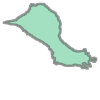

In [68]:
Multi

In [69]:
points  = np.array([point for point in Multi.exterior.coords])

/home/chris/anaconda3/envs/GISpy_1/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


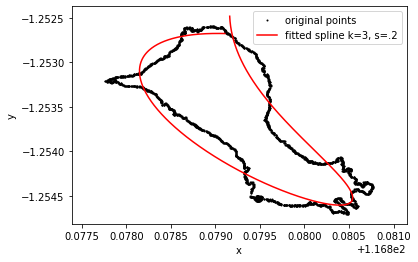

In [70]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import UnivariateSpline

# # Define some points:
# theta = np.linspace(-3, 2, 40)
# points = np.vstack( (np.cos(theta), np.sin(theta)) ).T

# # add some noise:
# points = points + 0.05*np.random.randn(*points.shape)

# Linear length along the line:
distance = np.cumsum( np.sqrt(np.sum( np.diff(points, axis=0)**2, axis=1 )) )
distance = np.insert(distance, 0, 0)/distance[-1]

# Build a list of the spline function, one for each dimension:
splines = [UnivariateSpline(distance, coords, k=5, s=2) for coords in points.T]

# splines.set_smoothing_factor(0.5)

# Computed the spline for the asked distances:
alpha = np.linspace(0,1,1000)
points_fitted = np.vstack( spl(alpha) for spl in splines ).T

# Graph:
plt.plot(*points.T, 'ok', label='original points',  markersize = 1);
plt.plot(*points_fitted.T, '-r', label='fitted spline k=3, s=.2');
plt.axis('equal'); plt.legend(); plt.xlabel('x'); plt.ylabel('y');

No handles with labels found to put in legend.


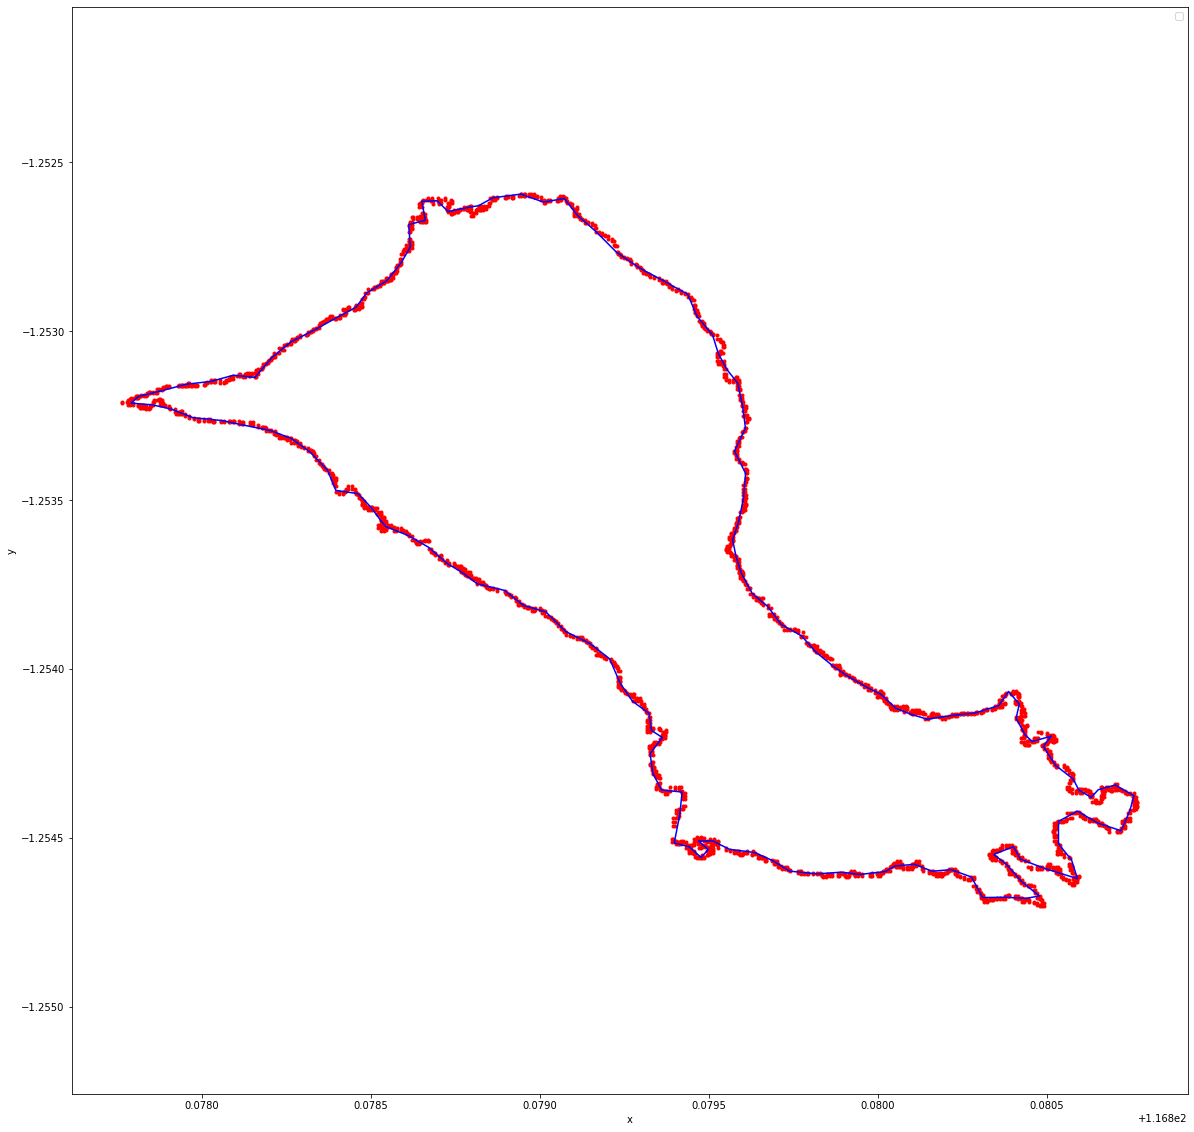

In [71]:
import numpy as np
from scipy.interpolate import splprep, splev
import matplotlib.pyplot as plt

# define pts from the question
pts = points

tck, u = splprep(pts.T, u=None, s=0.0, per=1) 
u_new = np.linspace(u.min(), u.max(), 150)            
x_new, y_new = splev(u_new, tck, der=0)

fig, ax = plt.subplots(figsize = (20,20))
plt.plot(pts[:,0], pts[:,1], 'r.')
plt.plot(x_new, y_new, 'b-')
plt.axis('equal'); plt.legend(); plt.xlabel('x'); plt.ylabel('y');
plt.show()